# Paths

In [1]:
dataset_path = "/home/juliamatos/Área de Trabalho/trabalhoCNN/datasets/ASDID"
tensorboard_path = "../logs/"
models_path = "../models/ASDID/"

# Dataloader

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# função para dividir o dataset em treino e teste
def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [4]:
# transformações para a ResNet18 
from torchvision.models import ResNet18_Weights
my_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

In [11]:
import torch
import torchvision
torch.cuda.empty_cache()


# carrega o dataset de imagens com as transformações definidas
data = torchvision.datasets.ImageFolder(root=dataset_path, transform=my_transform)

# divide o dataset em treino e teste
train_data, test_data = train_test_dataset(data, 0.30)

batch_size = 32


train_tensors = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_tensors = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
print(len(data))
print(len(train_data))
print(len(test_data))

10035
7024
3011


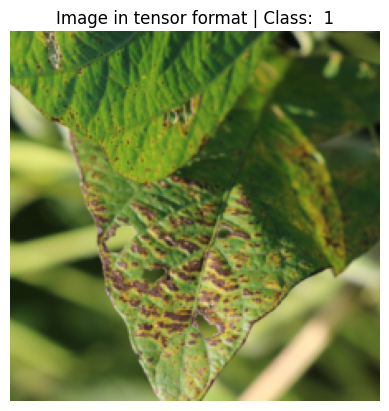

In [6]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

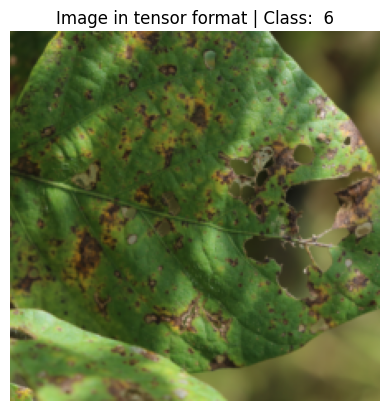

In [7]:
images, labels = next(iter(test_tensors))
my_tensor_image_show(images[0], label=labels[0])

# Training

In [19]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy

def plot_layers(net, writer, epoch):
    # Acessa a camada Conv2d final (camada 1 do classifier)
    final_conv = net.classifier[1]
    
    if isinstance(final_conv, torch.nn.Conv2d):
        writer.add_histogram('Weight/classifier_conv', final_conv.weight, epoch)
        if final_conv.weight.grad is not None:
            writer.add_histogram('Grad/classifier_conv', final_conv.weight.grad, epoch)


def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    # otimizador e função de perda
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
        
    accuracies = []
    max_accuracy = -1.0  

    for inputs, labels in train_loader:
        print("Labels:", labels.unique())
        break

    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)
            
            predict_y = net( train_x )
            
            # loss
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )
            
            # backpropagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )
        
        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        dataset = "ASDID"
        path = f'{models_path}SqueezeNet-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

# Validation

In [20]:
# função para validar o modelo
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

# Run

In [21]:
import torch
from torchvision.models import resnet18

# arquivo com modelo treinado no dataset SoyNet
path = '/home/juliamatos/Área de Trabalho/trabalhoCNN/CNN-Project/models/SoyNet/SqueezeNet-SoyNet-96.21.pkl'

# carrega o modelo
modelResNetTL = torch.load(path, weights_only=False)

# verifica as camadas
for name, param in modelResNetTL.named_parameters():
    print(f"{name}")


features.0.weight
features.0.bias
features.3.squeeze.weight
features.3.squeeze.bias
features.3.expand1x1.weight
features.3.expand1x1.bias
features.3.expand3x3.weight
features.3.expand3x3.bias
features.4.squeeze.weight
features.4.squeeze.bias
features.4.expand1x1.weight
features.4.expand1x1.bias
features.4.expand3x3.weight
features.4.expand3x3.bias
features.5.squeeze.weight
features.5.squeeze.bias
features.5.expand1x1.weight
features.5.expand1x1.bias
features.5.expand3x3.weight
features.5.expand3x3.bias
features.7.squeeze.weight
features.7.squeeze.bias
features.7.expand1x1.weight
features.7.expand1x1.bias
features.7.expand3x3.weight
features.7.expand3x3.bias
features.8.squeeze.weight
features.8.squeeze.bias
features.8.expand1x1.weight
features.8.expand1x1.bias
features.8.expand3x3.weight
features.8.expand3x3.bias
features.9.squeeze.weight
features.9.squeeze.bias
features.9.expand1x1.weight
features.9.expand1x1.bias
features.9.expand3x3.weight
features.9.expand3x3.bias
features.10.squeez

In [22]:
import torch.nn as nn

# Congela todas as camadas
for param in modelResNetTL.parameters():
    param.requires_grad = False

# Libera os parâmetros da camada convolucional final (Conv2d)
for param in modelResNetTL.classifier[1].parameters():
    param.requires_grad = True

# Substitui a última camada Conv2d para adaptar ao número de classes (11)
modelResNetTL.classifier[1] = nn.Conv2d(512, 11, kernel_size=(1, 1), stride=(1, 1))


In [25]:
# verifica as camadas que estão congeladas
for name, param in modelResNetTL.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

features.0.weight: Frozen
features.0.bias: Frozen
features.3.squeeze.weight: Frozen
features.3.squeeze.bias: Frozen
features.3.expand1x1.weight: Frozen
features.3.expand1x1.bias: Frozen
features.3.expand3x3.weight: Frozen
features.3.expand3x3.bias: Frozen
features.4.squeeze.weight: Frozen
features.4.squeeze.bias: Frozen
features.4.expand1x1.weight: Frozen
features.4.expand1x1.bias: Frozen
features.4.expand3x3.weight: Frozen
features.4.expand3x3.bias: Frozen
features.5.squeeze.weight: Frozen
features.5.squeeze.bias: Frozen
features.5.expand1x1.weight: Frozen
features.5.expand1x1.bias: Frozen
features.5.expand3x3.weight: Frozen
features.5.expand3x3.bias: Frozen
features.7.squeeze.weight: Frozen
features.7.squeeze.bias: Frozen
features.7.expand1x1.weight: Frozen
features.7.expand1x1.bias: Frozen
features.7.expand3x3.weight: Frozen
features.7.expand3x3.bias: Frozen
features.8.squeeze.weight: Frozen
features.8.squeeze.bias: Frozen
features.8.expand1x1.weight: Frozen
features.8.expand1x1.bia

In [ ]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}")
    
model = modelResNetTL.to(my_device)

epochs = 100
lr = 1e-4
dataset = 'ASDID'
prefix = 'ResNet18-Adam-TL-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

# treina o modelo
net = train(train_tensors, test_tensors, model, len(train_data),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

Running on cuda
Labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 9])


Training epochs...:   0%|          | 0/100 [00:00<?, ?it/s]

Sample id: 732
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
Hit
3
Predicted: Frogeye | Corrected: Frogeye | Confidence: 86.50%


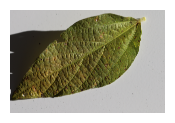

In [15]:
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=None)

    data = train_test_dataset(dataset, 0.30)[1]
    
    # my_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()
    i = np.random.randint(len(data))
    
    sample = data[i][0]
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow( sample )

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    print(x.shape)

    x = x.unsqueeze_(0)
    print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    dataset_classes = [
        "BacterialBlight", "CercosporaLeafBlight", "DowneyMildew", "Frogeye", "Healthy", "PotassiumDeficiency",
        "SoybeanRust", "TargetSpot", "UnusedCercosporaLeafBlight", "UnusedHealthy", "UnusedSoybeanRust"
    ]

    if predicted_class == data[i][1] : print('Hit')
    else: print('Miss')

    print(predicted_class)
    print( f'Predicted: {dataset_classes[predicted_class]} | Corrected: {dataset_classes[data[i][1]]} | Confidence: {confidence*100:.2f}%'  )
    
    # return dataset_classes[y], dataset_classes[data[i][1]], confidence

sample_and_predict(net)
